# Reguralization (Dropout, Normalization)
> ## 1. Library

> ## 2. MLP naive setting & Pre-process data

> ## 3. MLP batch norm
>> ### 3.1 with test phase
>> ### 3.2 with train, test phase

> ## 4. Dropout

> ## 5. Batch norm & Dropout

# Library

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

In [26]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print(f"device: {device}") if torch.cuda.is_available() else print("device: cpu")

device: cuda:1


# Hyper parameter setting

In [27]:
# hypter parameter setting
learning_rate = 1e-1 # normally, 1e-4부터 체크하면서 올림
epochs = 30
# batch_size = 60000 # gradient descent
# batch_size = 1 # stochastic gradient descent
batch_size = 32 # mini-batch SGD, 2의 배수
act = nn.Tanh()
h = 200
display_step = 5

# Load data & Pre-process data

len(train_data):  60000
len(test_data):  10000
original data shape:  torch.Size([1, 28, 28])
label:  5


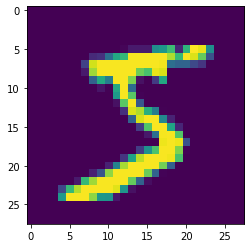

In [28]:
# load data
train_data = dataset.MNIST("./", train = True, 
                           transform = transforms.ToTensor(),
                           target_transform = None, # one-hot encoding 할지 여부
                           download = True)
test_data = dataset.MNIST("./", train = False,
                          transform = transforms.ToTensor(),
                          target_transform = None,
                          download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('original data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

processed data shape: torch.Size([32, 1, 28, 28])
label: tensor([9, 5, 7, 1, 5, 1, 0, 6, 5, 3, 6, 5, 2, 3, 6, 3, 3, 4, 4, 5, 3, 2, 7, 9,
        4, 5, 5, 6, 2, 5, 4, 6])


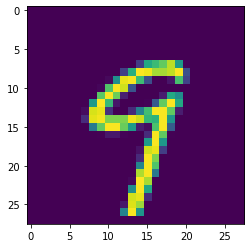

In [29]:
# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = batch_size,
                                           shuffle = True, # 섞을지 여부
                                           num_workers = 1,
                                           drop_last = True) # 남는 거 버릴지 여부
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size = 10000,
                                          shuffle = True,
                                          num_workers = 1,
                                          drop_last = True)

# check the data (배치 중 하나만 가져와서 확인)
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('processed data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

# Model & Optimization and Loss function

In [30]:
# model
model = nn.Sequential(
        nn.Linear(np.prod(x_train.shape[1:]),1024),
        act,
        nn.Linear(1024,300),
        act,
        nn.Linear(300,10)
        )

model = model.to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [31]:
loss_array = []
iteration_loss_array = []

# train the model
for epoch in range(epochs):
    for iteration, [data, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = data.to(device)
        x = x.view(batch_size, -1) # flatten
        y = label.to(device)
        
        output = model(x)
        loss = loss_function(output, y)
        
        loss.backward()
        optimizer.step()
        
        iteration_loss_array.append(loss.cpu().detach().numpy())
            
    loss_array.append(loss.cpu().detach().numpy())
    
    if epoch % display_step == 0:
        print("Epoch:", epoch + 1, "\Loss:", loss)

Epoch: 1 \Loss: tensor(0.1413, device='cuda:1', grad_fn=<NllLossBackward>)
Epoch: 6 \Loss: tensor(0.0303, device='cuda:1', grad_fn=<NllLossBackward>)
Epoch: 11 \Loss: tensor(0.0336, device='cuda:1', grad_fn=<NllLossBackward>)
Epoch: 16 \Loss: tensor(0.0052, device='cuda:1', grad_fn=<NllLossBackward>)
Epoch: 21 \Loss: tensor(0.0109, device='cuda:1', grad_fn=<NllLossBackward>)
Epoch: 26 \Loss: tensor(0.0004, device='cuda:1', grad_fn=<NllLossBackward>)


In [9]:
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

total 10000
correct tensor(9823., device='cuda:0')
accuracy tensor(0.9823, device='cuda:0')


## Plot result & Confusion matrix

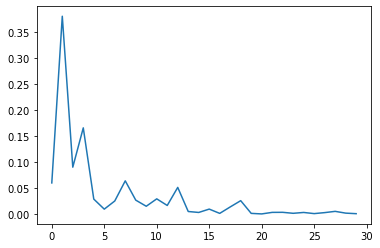

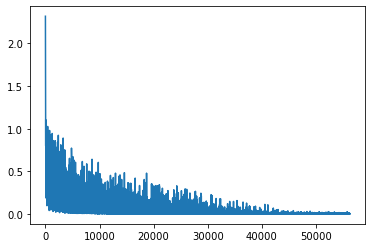

prediction : (10000,)
true label : (10000,)


array([[ 972,    0,    2,    0,    0,    1,    2,    1,    2,    0],
       [   0, 1128,    0,    2,    0,    1,    2,    1,    1,    0],
       [   4,    1, 1013,    3,    1,    0,    2,    4,    4,    0],
       [   0,    1,    3,  993,    0,    2,    0,    2,    3,    6],
       [   0,    0,    3,    0,  961,    0,    5,    2,    0,   11],
       [   3,    0,    0,    9,    1,  871,    3,    1,    2,    2],
       [   2,    2,    1,    0,    3,    5,  944,    0,    1,    0],
       [   1,    3,    7,    2,    2,    0,    0, 1004,    3,    6],
       [   3,    0,    2,    3,    1,    5,    0,    3,  955,    2],
       [   1,    2,    0,    6,    7,    3,    0,    7,    1,  982]])

In [10]:
# plot losses
plt.figure()
plt.plot(loss_array)
plt.show()
# plot iteration losses
plt.figure()
plt.plot(iteration_loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

# Build FC Layer Model
## (Show inner distribution)

In [11]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        self.fc1 = nn.Linear(784, self.hidden1)
        self.act1 = nn.Tanh()
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.act2 = nn.Tanh()
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        hidden1 = self.act1(output1)

        output2 = self.fc2(hidden1)
        hidden2 = self.act2(output2)
        
        logit = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [12]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        output1, hidden1, output2, hidden2, logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())

    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        output1, hidden1, output2, hidden2, prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.1539202183485031
5 epoch loss: 0.2429370880126953
10 epoch loss: 0.04112796485424042
15 epoch loss: 0.004202350974082947
20 epoch loss: 0.0028076779562979937
25 epoch loss: 0.0021713795140385628
total 10000
correct tensor(9821., device='cuda:0')
accuracy tensor(0.9821, device='cuda:0')


## Plot result

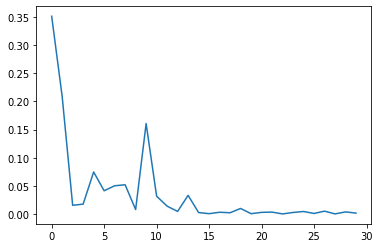

prediction : (10000,)
true label : (10000,)


array([[ 972,    0,    2,    1,    0,    0,    2,    1,    1,    1],
       [   0, 1127,    1,    2,    0,    1,    2,    1,    1,    0],
       [   5,    0, 1010,    4,    2,    0,    3,    3,    4,    1],
       [   0,    1,    4,  991,    0,    2,    0,    3,    4,    5],
       [   0,    1,    2,    1,  962,    0,    5,    2,    0,    9],
       [   3,    0,    0,    6,    1,  873,    3,    1,    3,    2],
       [   3,    2,    1,    0,    3,    4,  945,    0,    0,    0],
       [   1,    4,    8,    1,    1,    0,    0, 1004,    1,    8],
       [   2,    1,    2,    3,    3,    5,    1,    2,  952,    3],
       [   3,    2,    1,    4,    6,    2,    0,    4,    0,  987]],
      dtype=int64)

In [9]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

## Show inner distribution

torch.Size([10000, 784]) torch.Size([10000, 1024]) torch.Size([10000, 1024]) torch.Size([10000, 300]) torch.Size([10000, 300])


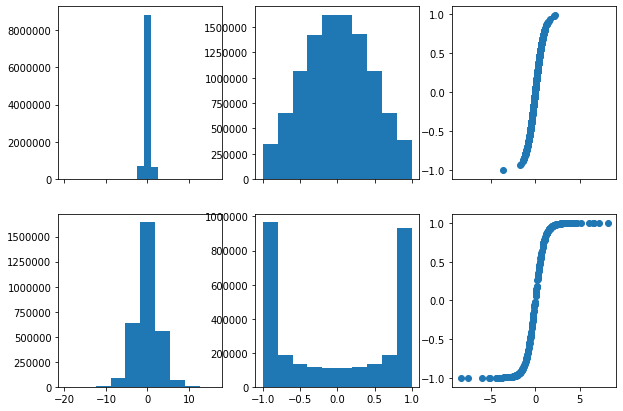

In [10]:
print(x.shape, output1.shape, hidden1.shape, output2.shape, hidden2.shape)

def plot_inner_dist(x, o1, h1, o2, h2):
    fig, axs = plt.subplots(2, 3, figsize=(10, 7), sharex='col')
    axs[0, 0].hist(o1.reshape(-1))
    axs[0, 1].hist(h1.reshape(-1))
    axs[0, 2].scatter(o1[0], h1[0])
    axs[1, 0].hist(o2.reshape(-1))
    axs[1, 1].hist(h2.reshape(-1))
    axs[1, 2].scatter(o2[0], h2[0])
    plt.show()
plot_inner_dist(x.cpu().numpy(), output1.cpu().numpy(), 
                hidden1.cpu().numpy(), output2.cpu().numpy(), hidden2.cpu().numpy())

# Add Batch Normalize Layers

In [13]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        # Add batch norm, before activation fn
        self.fc1 = nn.Linear(784, self.hidden1)
        self.bn1 = nn.BatchNorm1d(self.hidden1)
        self.act1 = nn.Tanh()
        
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.bn2 = nn.BatchNorm1d(self.hidden2)
        self.act2 = nn.Tanh()
        
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        bn1 = self.bn1(output1)
        hidden1 = self.act1(bn1)

        output2 = self.fc2(hidden1)
        bn2 = self.bn2(output2)
        hidden2 = self.act2(bn2)
        
        logit = self.fc3(hidden2)
        
        return output1, hidden1, output2, hidden2, logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [14]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        output1, hidden1, output2, hidden2, logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())
    
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        output1, hidden1, output2, hidden2, prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.24541041254997253
5 epoch loss: 0.17285044491291046
10 epoch loss: 0.0023874493781477213
15 epoch loss: 0.000787059310823679
20 epoch loss: 0.008904709480702877
25 epoch loss: 0.019810883328318596
total 10000
correct tensor(9840., device='cuda:0')
accuracy tensor(0.9840, device='cuda:0')


## Plot the result

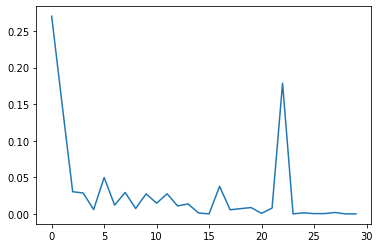

prediction : (10000,)
true label : (10000,)


array([[ 972,    1,    2,    0,    0,    1,    2,    1,    1,    0],
       [   1, 1126,    3,    1,    0,    0,    1,    1,    2,    0],
       [   1,    1, 1017,    0,    3,    0,    1,    6,    2,    1],
       [   0,    0,    2,  991,    0,    3,    0,    6,    3,    5],
       [   0,    0,    0,    0,  969,    0,    5,    1,    0,    7],
       [   3,    0,    0,    8,    1,  873,    2,    2,    2,    1],
       [   4,    4,    1,    0,    3,    2,  944,    0,    0,    0],
       [   0,    2,    5,    0,    0,    0,    0, 1016,    2,    3],
       [   2,    1,    4,    1,    2,    2,    0,    2,  958,    2],
       [   2,    5,    0,    4,    6,    1,    1,    5,    4,  981]],
      dtype=int64)

In [13]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

## Show inner distribution

torch.Size([10000, 784]) torch.Size([10000, 1024]) torch.Size([10000, 1024]) torch.Size([10000, 300]) torch.Size([10000, 300])


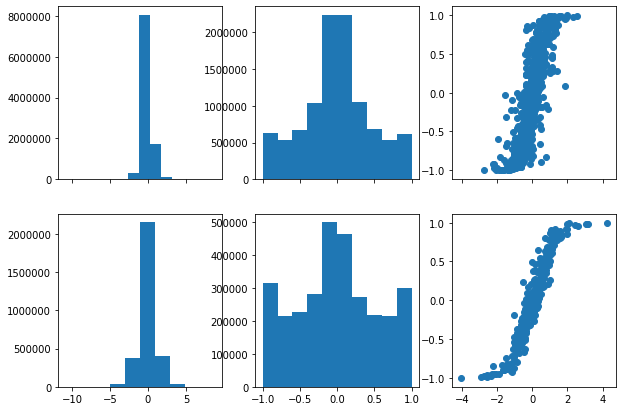

In [14]:
print(x.shape, output1.shape, hidden1.shape, output2.shape, hidden2.shape)

def plot_inner_dist(x, o1, h1, o2, h2):
    fig, axs = plt.subplots(2, 3, # 2*3 행렬
                            figsize=(10, 7), # 크기
                            sharex='col')
    axs[0, 0].hist(o1.reshape(-1))
    axs[0, 1].hist(h1.reshape(-1))
    axs[0, 2].scatter(o1[0], h1[0])
    axs[1, 0].hist(o2.reshape(-1))
    axs[1, 1].hist(h2.reshape(-1))
    axs[1, 2].scatter(o2[0], h2[0])
    plt.show()
    
plot_inner_dist(x.cpu().numpy(), output1.cpu().numpy(), 
                hidden1.cpu().numpy(), output2.cpu().numpy(), hidden2.cpu().numpy())

# Add Dropout Layers

In [22]:
# hyper parameter setting
learning_rate = 1e-1
epochs = 100
# batch_size = 60000 # gradient descent
# batch_size = 1 # stochastic gradient descent
batch_size = 32 # mini-batch stochastic gradient descent
act = nn.Tanh()
h = 200
display_step = 10
dropout_rate = .2 # probability to be 0 

In [16]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        self.fc1 = nn.Linear(784, self.hidden1)
        self.act1 = nn.Tanh()
        self.drop1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.act2 = nn.Tanh()
        self.drop2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        hidden1 = self.act1(output1)
        drop1 = self.drop1(hidden1)
        
        output2 = self.fc2(drop1)
        hidden2 = self.act2(output2)
        drop2 = self.drop2(hidden2)
        
        logit = self.fc3(drop2)
        
        return logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [17]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())
    
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.07231049239635468
10 epoch loss: 0.0030768364667892456
20 epoch loss: 0.008133232593536377
30 epoch loss: 0.25888490676879883
40 epoch loss: 0.000361025333404541
50 epoch loss: 0.0009654760360717773
60 epoch loss: 0.0002760589122772217
70 epoch loss: 8.392333984375e-05
80 epoch loss: 0.005643606185913086
90 epoch loss: 0.0022919774055480957
total 10000
correct tensor(9837., device='cuda:0')
accuracy tensor(0.9837, device='cuda:0')


## Plot result

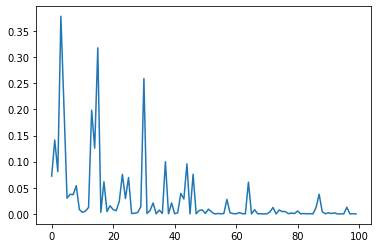

prediction : (10000,)
true label : (10000,)


array([[ 974,    0,    2,    0,    0,    0,    0,    1,    2,    1],
       [   0, 1126,    3,    2,    0,    0,    1,    1,    2,    0],
       [   6,    0, 1018,    1,    2,    0,    0,    1,    4,    0],
       [   0,    0,    3,  994,    0,    5,    0,    3,    3,    2],
       [   1,    0,    1,    1,  958,    0,    5,    2,    2,   12],
       [   5,    0,    0,    2,    0,  874,    5,    1,    3,    2],
       [   3,    2,    1,    0,    3,    3,  946,    0,    0,    0],
       [   0,    1,   13,    2,    1,    0,    0, 1006,    1,    4],
       [   3,    0,    3,    2,    1,    2,    1,    1,  960,    1],
       [   1,    2,    0,    5,    5,    7,    1,    5,    2,  981]],
      dtype=int64)

In [18]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

# Add Batch norm, Dropout Layers

In [17]:
# model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10

        # Add batch norm, before activation fn
        # Add drop out, after activation fn
        self.fc1 = nn.Linear(784, self.hidden1)
        self.bn1 = nn.BatchNorm1d(self.hidden1)
        self.act1 = nn.Tanh()
        self.drop1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.bn2 = nn.BatchNorm1d(self.hidden2)
        self.act2 = nn.Tanh()
        self.drop2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(self.hidden2, self.final)

    def forward(self, x):
        output1 = self.fc1(x)
        bn1 = self.bn1(output1)
        hidden1 = self.act1(bn1)
        drop1 = self.drop1(hidden1)

        output2 = self.fc2(drop1)
        bn2 = self.bn2(output2)
        hidden2 = self.act2(bn2)
        drop2 = self.drop2(hidden2)
        
        logit = self.fc3(drop2)
        
        return logit

model = MLP().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [18]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        data = data.view(batch_size, -1)
        logit = model.forward(data)
        loss = loss_function(logit, label)
        loss.backward()
        optimizer.step()
        
    loss_array.append(loss.cpu().detach().numpy())
    
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        
        
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model.forward(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

0 epoch loss: 0.4359529912471771
10 epoch loss: 0.13927322626113892
20 epoch loss: 0.0955144539475441
30 epoch loss: 0.009655768983066082
40 epoch loss: 8.801374497124925e-05
50 epoch loss: 0.0016734719974920154
60 epoch loss: 0.0022674589417874813
70 epoch loss: 0.02700456790626049
80 epoch loss: 0.011523504741489887
90 epoch loss: 0.00013890053378418088
total 10000
correct tensor(9852., device='cuda:0')
accuracy tensor(0.9852, device='cuda:0')


## Plot result

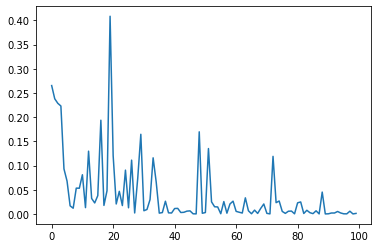

prediction : (10000,)
true label : (10000,)


array([[ 974,    1,    2,    0,    0,    1,    0,    1,    1,    0],
       [   1, 1125,    3,    0,    0,    0,    2,    1,    3,    0],
       [   1,    1, 1020,    2,    0,    0,    1,    3,    3,    1],
       [   0,    0,    2,  997,    0,    2,    0,    4,    3,    2],
       [   2,    0,    1,    1,  965,    0,    4,    0,    1,    8],
       [   2,    0,    0,   10,    1,  870,    4,    1,    3,    1],
       [   3,    2,    1,    1,    2,    3,  946,    0,    0,    0],
       [   0,    3,    9,    2,    0,    0,    0, 1011,    2,    1],
       [   2,    1,    2,    2,    2,    4,    0,    2,  957,    2],
       [   3,    3,    0,    7,    5,    1,    0,    2,    2,  986]],
      dtype=int64)

In [21]:
plt.figure()
plt.plot(loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

# Advanced: batch norm + dropout in CNN

In [23]:
test_loader = torch.utils.data.DataLoader(test_data, 
                                          batch_size = batch_size,
                                          shuffle = True,
                                          num_workers = 1,
                                          drop_last = True)

# batchnorm + dropout in CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding =1), # 28 x 28
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Conv2d(16, 32, 3, padding =1), # 14 x 14 
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2,2) # 7 x 7
        )
        self.classifier = nn.Sequential(
            nn.Linear(32*7*7,100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(100,10)
        )
    def forward(self, x):
        feature_extraction = self.feature_extraction(x)
        flatten = feature_extraction.view(batch_size, -1)         
        logit = self.classifier(flatten)
        
        return logit
        
model = CNN().to(device)
model.train()

# loss and optimizer
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

# Train & Test

In [24]:
loss_array = []

# train the model
for i in range(epochs):
    for index, [data, label] in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)
                
        optimizer.zero_grad()
        output = model.forward(data)
        loss = loss_function(output, label)
        loss.backward()
        optimizer.step()
        
    if i % display_step == 0:
        print('{} epoch loss: {}'.format(i,loss))
        loss_array.append(loss.cpu().detach().numpy())
        
#test the model
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for index, [data, label] in enumerate(test_loader):
        data = data.to(device)
        label = label.to(device)
        
        output = model.forward(data)
        _, prediction_index = torch.max(output, 1)
        
        prediction_list.append(prediction_index)
        label_list.append(label)
        
        total += label.size(0)
        correct += (prediction_index == label).sum().float()

    print("Accuracy of the model: {}".format(correct/total))

0 epoch loss: 0.011132486164569855
10 epoch loss: 0.002545156516134739
20 epoch loss: 8.151181100402027e-05
30 epoch loss: 0.00032701590680517256
40 epoch loss: 0.0002960831334348768
50 epoch loss: 9.826707355387043e-06
60 epoch loss: 0.0001407579838996753
70 epoch loss: 7.440480112563819e-05
80 epoch loss: 0.00011824071407318115
90 epoch loss: 1.8179194967160583e-06
Accuracy of the model: 0.9928886294364929
